## Notebook Setup 
The following cell will install Drake, checkout the underactuated repository, and set up the path (only if necessary).
- On Google's Colaboratory, this **will take approximately two minutes** on the first time it runs (to provision the machine), but should only need to reinstall once every 12 hours.  Colab will ask you to "Reset all runtimes"; say no to save yourself the reinstall.
- On Binder, the machines should already be provisioned by the time you can run this; it should return (almost) instantly.

More details are available [here](http://underactuated.mit.edu/drake.html).

In [1]:
try:
  import pydrake
  import underactuated
except ImportError:
  !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
  from jupyter_setup import setup_underactuated
  setup_underactuated()

## LQR for the Acrobot

/home/sheep/.local/lib/python3.6/site-packages/ipykernel_launcher.py:31: DrakeDeprecationWarning: Use input_port.FixValue() instead of context.FixInputPort(). This will be removed from Drake on or after 2021-01-01.


<IPython.core.display.Javascript object>


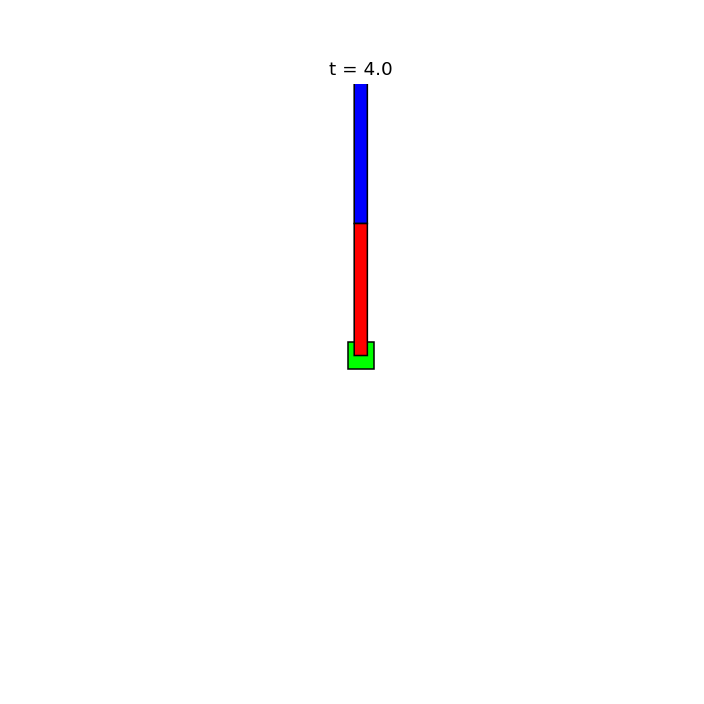

In [3]:
import matplotlib.pyplot as plt
import numpy as np

from pydrake.all import (DiagramBuilder, LinearQuadraticRegulator,
                         PlanarSceneGraphVisualizer, Saturation,
                         SceneGraph, Simulator, WrapToSystem)
from pydrake.examples.acrobot import (AcrobotInput, AcrobotGeometry, 
                                      AcrobotPlant, AcrobotState)
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend, running_as_notebook
plt_is_interactive = SetupMatplotlibBackend()

def UprightState():
    state = AcrobotState()
    state.set_theta1(np.pi)
    state.set_theta2(0.)
    state.set_theta1dot(0.)
    state.set_theta2dot(0.)
    return state


def BalancingLQR():
    # Design an LQR controller for stabilizing the Acrobot around the upright.
    # Returns a (static) AffineSystem that implements the controller (in
    # the original AcrobotState coordinates).

    acrobot = AcrobotPlant()
    context = acrobot.CreateDefaultContext()

    input = AcrobotInput()
    input.set_tau(0.)
    context.FixInputPort(0, input)

    context.get_mutable_continuous_state_vector()\
        .SetFromVector(UprightState().CopyToVector())

    Q = np.diag((10., 10., 1., 1.))
    R = [1]

    return LinearQuadraticRegulator(acrobot, context, Q, R)


builder = DiagramBuilder()
acrobot = builder.AddSystem(AcrobotPlant())

saturation = builder.AddSystem(Saturation(min_value=[-10], max_value=[10]))
builder.Connect(saturation.get_output_port(0), acrobot.get_input_port(0))
wrapangles = WrapToSystem(4)
wrapangles.set_interval(0, 0, 2. * np.pi)
wrapangles.set_interval(1, -np.pi, np.pi)
wrapto = builder.AddSystem(wrapangles)
builder.Connect(acrobot.get_output_port(0), wrapto.get_input_port(0))
controller = builder.AddSystem(BalancingLQR())
builder.Connect(wrapto.get_output_port(0), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0), saturation.get_input_port(0))

# Setup visualization
scene_graph = builder.AddSystem(SceneGraph())
AcrobotGeometry.AddToBuilder(builder, acrobot.get_output_port(0), scene_graph)
visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph, xlim=[-4., 4.], ylim=[-4., 4.], show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

# Simulate
duration = 4.0 if running_as_notebook else 0.1 # sets a shorter duration during testing
if not visualizer._show:
    visualizer.start_recording()
for i in range(5):
    context.SetTime(0.)
    context.SetContinuousState(UprightState().CopyToVector() +
                               0.05 * np.random.randn(4,))
    simulator.Initialize()
    if i<4:
        simulator.AdvanceTo(duration)
    else:
        AdvanceToAndVisualize(simulator, visualizer, duration)

## LQR for the Cart-Pole

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from pydrake.all import (AddMultibodyPlantSceneGraph, DiagramBuilder, 
                         LinearQuadraticRegulator, Parser, PlanarSceneGraphVisualizer, 
                         SceneGraph, Simulator)
from underactuated import FindResource
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend, running_as_notebook
plt_is_interactive = SetupMatplotlibBackend()

def UprightState():
    state = (0, np.pi, 0, 0)
    return state


def BalancingLQR(plant):
    # Design an LQR controller for stabilizing the CartPole around the upright.
    # Returns a (static) AffineSystem that implements the controller (in
    # the original CartPole coordinates).

    context = plant.CreateDefaultContext()
    plant.get_actuation_input_port().FixValue(context, [0])

    context.get_mutable_continuous_state_vector().SetFromVector(UprightState())

    Q = np.diag((10., 10., 1., 1.))
    R = [1]

    # MultibodyPlant has many (optional) input ports, so we must pass the
    # input_port_index to LQR.
    return LinearQuadraticRegulator(
        plant,
        context,
        Q,
        R,
        input_port_index=plant.get_actuation_input_port().get_index())


builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
file_name = FindResource("models/cartpole.urdf")
Parser(plant).AddModelFromFile(file_name)
plant.Finalize()

controller = builder.AddSystem(BalancingLQR(plant))
builder.Connect(plant.get_state_output_port(), controller.get_input_port(0))
builder.Connect(controller.get_output_port(0),
                plant.get_actuation_input_port())

# Setup visualization
visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph, xlim=[-2.5, 2.5], ylim=[-1, 2.5], show=plt_is_interactive))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

# Simulate
duration = 8.0 if running_as_notebook else 0.1 # sets a shorter duration during testing
if not visualizer._show:
    visualizer.start_recording()
for i in range(5):
    context.SetTime(0.)
    context.SetContinuousState(UprightState() + 0.1 * np.random.randn(4,))
    simulator.Initialize()
    if i<4:
        simulator.AdvanceTo(duration)
    else:
        AdvanceToAndVisualize(simulator, visualizer, duration)

## LQR for the Planar Quadrotor

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from pydrake.all import DiagramBuilder, LinearQuadraticRegulator, Simulator
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer
from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend, running_as_notebook
plt_is_interactive = SetupMatplotlibBackend()


def QuadrotorLQR(plant):
    context = plant.CreateDefaultContext()
    context.SetContinuousState(np.zeros([6, 1]))
    context.FixInputPort(0, plant.mass * plant.gravity / 2. * np.array([1, 1]))

    Q = np.diag([10, 10, 10, 1, 1, (plant.length / 2. / np.pi)])
    R = np.array([[0.1, 0.05], [0.05, 0.1]])

    return LinearQuadraticRegulator(plant, context, Q, R)


builder = DiagramBuilder()
plant = builder.AddSystem(Quadrotor2D())

controller = builder.AddSystem(QuadrotorLQR(plant))
builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

# Setup visualization
visualizer = builder.AddSystem(Quadrotor2DVisualizer(show=plt_is_interactive))
builder.Connect(plant.get_output_port(0), visualizer.get_input_port(0))

diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

# Simulate
duration = 4.0 if running_as_notebook else 0.1 # sets a shorter duration during testing
if not visualizer._show:
    visualizer.start_recording()
for i in range(5):
    context.SetTime(0.)
    context.SetContinuousState(np.random.randn(6,))
    simulator.Initialize()
    if i<4:
        simulator.AdvanceTo(duration)
    else:
        AdvanceToAndVisualize(simulator, visualizer, duration)

## LQR for the 3D Quadrotor

This example requires a 3D visualizer, and does not work [yet](https://github.com/rdeits/meshcat/issues/67#issuecomment-632453885) on Colab (but should work on Binder).  

In [3]:
import numpy as np

from pydrake.all import (DiagramBuilder,
                         MeshcatVisualizer,
                         SceneGraph,
                         Simulator,
                         VectorSystem)
from pydrake.examples.quadrotor import (QuadrotorPlant,
                                        StabilizingLQRController,
                                        QuadrotorGeometry)
from underactuated.jupyter import running_as_notebook

builder = DiagramBuilder()

plant = builder.AddSystem(QuadrotorPlant())

controller = builder.AddSystem(StabilizingLQRController(plant, [0, 0, 1]))
builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

# Set up visualization in MeshCat
scene_graph = builder.AddSystem(SceneGraph())
QuadrotorGeometry.AddToBuilder(builder, plant.get_output_port(0), scene_graph)
visualizer = builder.AddSystem(
    MeshcatVisualizer(scene_graph, zmq_url="new", open_browser=False))
builder.Connect(scene_graph.get_pose_bundle_output_port(),
                visualizer.get_input_port(0))
# end setup for visualization

diagram = builder.Build()

simulator = Simulator(diagram)
#simulator.set_target_realtime_rate(1.0)
context = simulator.get_mutable_context()

duration = 4.0 if running_as_notebook else 0.1 # sets a shorter duration during testing
visualizer.start_recording()
print('simulating...')
for i in range(5):
    context.SetTime(0.)
    context.SetContinuousState(np.random.randn(12,))
    simulator.Initialize()
    simulator.AdvanceTo(duration)
visualizer.publish_recording()
if running_as_notebook:
    visualizer.vis.render_static()


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Connected to meshcat-server.
simulating...
